<a href="https://colab.research.google.com/github/camilodlt/rtidy-python/blob/main/rtidy-python/Computer%20vision/CIFAR/Submodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Customizing Graph-structured AutoML Pipeline** 

In [1]:
%%capture
!pip install tensorflow==2.3.0
!pip install autokeras==1.0.16
!pip install keras_tuner==1.0.3

In [2]:
import keras_tuner
keras_tuner.__version__

'1.0.3'

In [3]:

# import the python packages
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow import keras

import autokeras as ak

print( "tf.__version__:", tf.__version__ )
print( "ak.__version__:", ak.__version__ )

tf.__version__: 2.3.0
ak.__version__: 1.0.16


In [4]:
!nvidia-smi

Sun Sep 26 12:48:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import tensorflow as tf 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load dataset

#### Load cifar10 dataset

In [6]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
print('Training image shape:', x_train.shape)
print('Training label shape:', y_train.shape)
print('Testing image shape:', x_test.shape)
print('Testing label shape:', y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
Training image shape: (50000, 32, 32, 3)
Training label shape: (50000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


In [7]:
# Sample the Dataset ------
from sklearn.utils import resample
x_train_sampled, y_train_sampled = resample(x_train, y_train, n_samples=10000, replace=False, random_state=0)

Training image shape: (10000, 32, 32, 3)
Training label shape: (10000, 1)
Testing image shape: (10000, 32, 32, 3)
Testing label shape: (10000, 1)


#### Prepare data

In [8]:
# scale
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# reshape
x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)

## Build the graph-structured deep learning model

#### Build model with Functional API

In [9]:
hp = keras_tuner.HyperParameters()
num_blocks=keras_tuner.engine.hyperparameters.Choice("num_blocks",values=[2])
num_layers=keras_tuner.engine.hyperparameters.Choice("num_layers",values=[1])

inputs = ak.ImageInput()

# Build a graph-structured AutoML pipeline

# Branch 1
branch1 = ak.Normalization()(inputs)
branch1 = ak.ImageAugmentation()(branch1)
branch1_outputs = ak.ConvBlock(num_blocks=num_blocks, num_layers=num_layers)(branch1)

# Branch 2
branch2 = ak.Normalization()(inputs)
branch2 = ak.ImageAugmentation()(branch2)
branch2 = ak.ConvBlock(num_blocks=num_blocks, num_layers=num_layers)(branch2)

# Subbranch 1 of branch 2
branch2_1 = ak.Normalization()(branch2)
branch2_1 = ak.ConvBlock(num_blocks=num_blocks, num_layers=num_layers)(branch2_1)

# Subbranch 2 of branch 2
# Your code here
branch2_2 = ak.Normalization()(branch2)
branch2_2 = ak.ConvBlock(num_blocks=num_blocks, num_layers=num_layers)(branch2_2)

# Merge subbranch 1 and 2
branch2_outputs = ak.Merge()([branch2_1, branch2_2])

# Merge branch 1 and 2
outputs = ak.Merge()([branch1_outputs, branch2_outputs])

outputs = ak.ClassificationHead()(outputs)

#### Train model

In [22]:
clf = ak.AutoModel(
    inputs=inputs, 
    outputs=outputs,
    max_trials=3,
    overwrite=True,
    seed=42)

clf.fit(x_train, y_train, epochs=3) # ,epochs=3, verbose=2

Trial 3 Complete [00h 00m 45s]
val_loss: 1.2061964273452759

Best val_loss So Far: 1.2061964273452759
Total elapsed time: 00h 02m 15s
INFO:tensorflow:Oracle triggered exit
Epoch 1/3
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6087 - accuracy: 0.4047
Epoch 2/3
1563/1563 [==============================] - 12s 8ms/step - loss: 1.2905 - accuracy: 0.5335
Epoch 3/3
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1565 - accuracy: 0.5883
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


## Explore Model

In [23]:
# Get the summarized results during the tuning process (return the best 10 models if existed)
clf.tuner.results_summary()

Results summary
Results in ./auto_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
image_augmentation_1/translation_factor: 0.0
image_augmentation_1/horizontal_flip: True
image_augmentation_1/vertical_flip: True
image_augmentation_1/rotation_factor: 0.0
image_augmentation_1/zoom_factor: 0.0
image_augmentation_1/contrast_factor: 0.0
image_augmentation_2/translation_factor: 0.0
image_augmentation_2/horizontal_flip: True
image_augmentation_2/vertical_flip: True
image_augmentation_2/rotation_factor: 0.0
image_augmentation_2/zoom_factor: 0.0
image_augmentation_2/contrast_factor: 0.0
conv_block_1/kernel_size: 3
conv_block_1/separable: False
conv_block_1/max_pooling: True
conv_block_1/dropout: 0
conv_block_1/num_blocks: 2
conv_block_1/num_layers: 1
conv_block_1/filters_0_0: 512
conv_block_1/filters_1_0: 32
conv_block_2/kernel_size: 3
conv_block_2/separable: False
conv_block_2/max_pooling: True
conv_block_2/dropout: 0
conv_block_2/num_bloc

In [24]:
#Retrieve best model
best_model = clf.export_model()
best_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 32, 32, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 32, 32, 3)    7           cast_to_float32[0][0]            
__________________________________________________________________________________________________
random_flip_1 (RandomFlip)      (None, 32, 32, 3)    0           normalization_1[0][0]            
_______________________________________________________________________________________

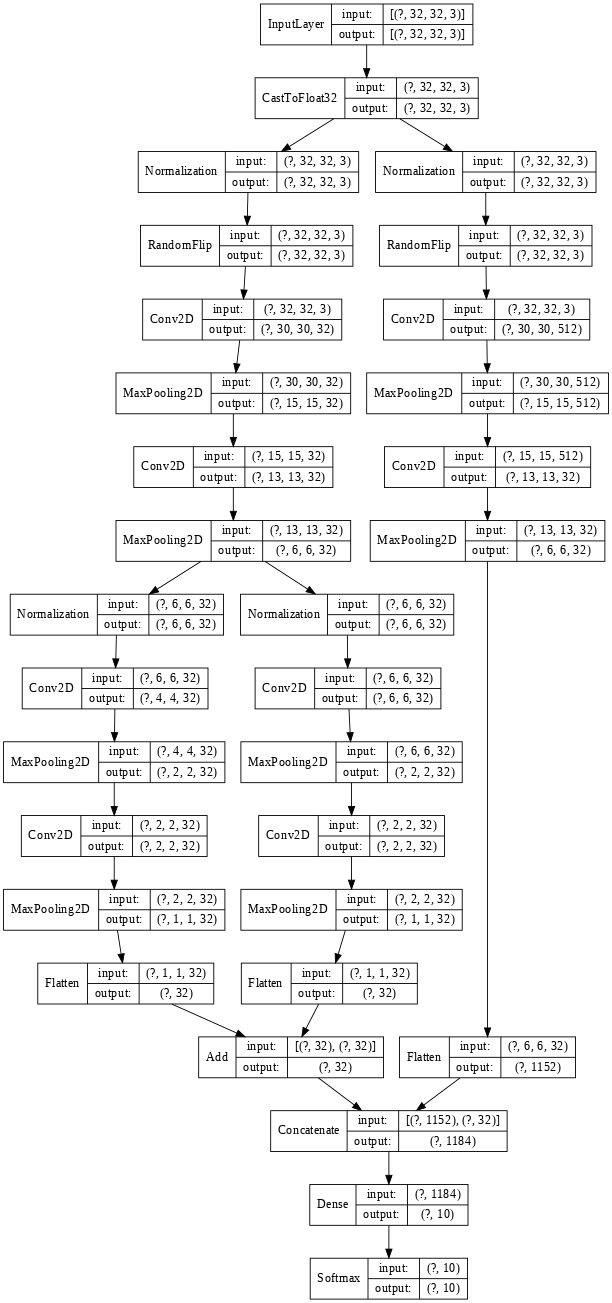

In [25]:
# Converts a Keras model to dot format and plot an image
tf.keras.utils.plot_model(best_model, show_layer_names=False, show_shapes=True, expand_nested=True, dpi=64)

## Retrain and evaluate searched model

In [26]:
# compile the model and train the model
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
best_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.10)

Epoch 1/10
704/704 [==============================] - 7s 10ms/step - loss: 1.0530 - accuracy: 0.6255 - val_loss: 0.9739 - val_accuracy: 0.6518
Epoch 2/10
704/704 [==============================] - 7s 10ms/step - loss: 1.0033 - accuracy: 0.6454 - val_loss: 1.0026 - val_accuracy: 0.6390
Epoch 3/10
704/704 [==============================] - 7s 10ms/step - loss: 0.9675 - accuracy: 0.6574 - val_loss: 0.9342 - val_accuracy: 0.6760
Epoch 4/10
704/704 [==============================] - 7s 10ms/step - loss: 0.9375 - accuracy: 0.6695 - val_loss: 0.9182 - val_accuracy: 0.6786
Epoch 5/10
704/704 [==============================] - 7s 10ms/step - loss: 0.9071 - accuracy: 0.6772 - val_loss: 0.9137 - val_accuracy: 0.6758
Epoch 6/10
704/704 [==============================] - 7s 10ms/step - loss: 0.8878 - accuracy: 0.6852 - val_loss: 0.9023 - val_accuracy: 0.6774
Epoch 7/10
704/704 [==============================] - 7s 10ms/step - loss: 0.8669 - accuracy: 0.6941 - val_loss: 0.8912 - val_accuracy: 0.6828

In [27]:
init= 10 

In [28]:
best_model.fit(x_train, y_train, epochs=init+2, batch_size=64, validation_split=0.10, initial_epoch=init)
init+=2

Epoch 11/12
704/704 [==============================] - 7s 10ms/step - loss: 0.8037 - accuracy: 0.7128 - val_loss: 0.8469 - val_accuracy: 0.7016
Epoch 12/12
704/704 [==============================] - 7s 10ms/step - loss: 0.7946 - accuracy: 0.7193 - val_loss: 0.8524 - val_accuracy: 0.6934


#### Evaluate the searched model

In [29]:
# evaluate the model
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.8916 - accuracy: 0.6809
Test loss:  0.8915851712226868
Test accuracy:  0.680899977684021
